Groundwater | Case Study

# Topic 4b : From Concept to Code: Adding Transport Processes to a Groundwater Flow Model

Dr. Xiang-Zhao Kong & Dr. Beatrice Marti & Louise Noël du Payrat

---
## 1. Introduction to Contaminant Transport Modeling

Contaminant transport in groundwater is governed by physical, chemical, and biological processes. Understanding these processes is essential for predicting plume migration, assessing risks, and designing remediation strategies.

### 1.1 Fundamental Transport Processes

**Advection** is the movement of dissolved contaminants with flowing groundwater:

$$v = \frac{K \cdot i}{n}$$

where $v$ is pore water velocity (m/day), $K$ is hydraulic conductivity (m/day), $i$ is hydraulic gradient (m/m), and $n$ is effective porosity (dimensionless).

**Dispersion** causes spreading of the contaminant plume beyond what advection alone would predict. It results from:
- **Mechanical dispersion**: Variations in velocity at pore scale and between flow paths
- **Molecular diffusion**: Random motion of molecules (typically negligible compared to mechanical dispersion)

**Sorption** is the attachment of contaminants to aquifer solids, causing **retardation**:

$$R = 1 + \frac{\rho_b \cdot K_d}{n}$$

where $R$ is the retardation factor (dimensionless), $\rho_b$ is bulk density (kg/m³), and $K_d$ is the distribution coefficient (mL/g).

**Decay** represents biodegradation or chemical transformation:

$$C(t) = C_0 \cdot e^{-\lambda t}$$

where $\lambda$ is the first-order decay constant (1/day), related to half-life by $t_{1/2} = \ln(2)/\lambda$.

### 1.2 Governing Equation

The 3D advection-dispersion-reaction equation describes contaminant transport:

$$
\frac{\partial C}{\partial t} = \nabla \cdot (D \nabla C) - \mathbf{v} \cdot \nabla C - \lambda C
$$

where:
- $C$ = concentration (mg/L)
- $t$ = time (days)
- $D$ = dispersion tensor (m²/day)
- $\mathbf{v}$ = velocity vector (m/day)
- $\lambda$ = decay constant (1/day)

For reactive transport, multiply $\frac{\partial C}{\partial t}$ by retardation factor $R$.

### 1.3 Analytical vs. Numerical Solutions

**Analytical solutions** exist for simplified conditions (1D, uniform flow, simple boundaries). **Example**: Ogata-Banks solution for 1D continuous source:

$$C(x,t) = \frac{C_0}{2}\left[\text{erfc}\left(\frac{x-vt}{2\sqrt{Dt}}\right) + e^{vx/D}\text{erfc}\left(\frac{x+vt}{2\sqrt{Dt}}\right)\right]$$

**Numerical solutions** (MT3D-USGS, MODFLOW 6 GWT) handle complex 2D/3D geometries, heterogeneity, wells, and boundaries.

### 1.4 MT3D-USGS: Modular Transport Simulator

MT3D-USGS (Bedekar et al., 2016) is the USGS version of MT3DMS, coupled with MODFLOW. It uses a **modular package structure**:

| Package | Purpose | Key Parameters |
|---------|---------|----------------|
| **BTN** | Basic Transport | Porosity, initial concentration, time steps |
| **ADV** | Advection | Numerical scheme (MOC, TVD, etc.) |
| **DSP** | Dispersion | Dispersivity ($\alpha_L$, $\alpha_T$, $\alpha_V$) |
| **SSM** | Source-Sink Mixing | Source locations and concentrations |
| **RCT** | Reactions | Sorption ($K_d$), decay ($\lambda$) |
| **GCG** | Solver | Convergence criteria |

MT3D reads flow velocities from MODFLOW output and solves transport on the same (or refined) grid.

### 1.5 When to Use Which Method?

```
Simple problem? → Try analytical first
├─ Uniform flow, 1D, no wells → Ogata-Banks
├─ Conservative tracer only → Particle tracking (MODPATH)
└─ Need verification → Always compare numerical to analytical

Complex problem? → Use numerical model
├─ Wells, boundaries, heterogeneity → MT3D-USGS
├─ Multiple contaminants → MT3D-USGS (multi-species)
└─ Regulatory/design decisions → MT3D-USGS (defensible)
```

**Professional practice**: Start simple, add complexity only when justified. Always verify numerical models against analytical solutions.

### 1.6 References

- Sale, T., & Scalia, J. (2025). Modern Subsurface Contaminant Hydrology, first edition. The Groundwater Project. [https://doi.org/10.62592/IQDO4854](https://doi.org/10.62592/IQDO4854).
- Bedekar, Vivek, Morway, E.D., Langevin, C.D., and Tonkin, Matt, 2016, MT3D-USGS version 1: A U.S. Geological Survey release of MT3DMS updated with new and expanded transport capabilities for use with MODFLOW: U.S. Geological Survey Techniques and Methods 6-A53, 69 p., [https://dx.doi.org/10.3133/tm6A53](https://dx.doi.org/10.3133/tm6A53).
- Ogata, A., & Banks, R.B. (1961). *Longitudinal Dispersion in Porous Media*. USGS Professional Paper 411-A. [https://pubs.usgs.gov/pp/0411a/report.pdf](https://pubs.usgs.gov/pp/0411a/report.pdf).
- Gelhar, L.W., et al. (1992). Field-scale dispersion in aquifers. *Water Resources Research*, 28(7), 1955-1974. [https://doi.org/10.1029/92WR00607](https://doi.org/10.1029/92WR00607).

---

Let's now see these concepts in practice with code examples in Section 2.

---
## 2. Transport Model Setup Fundamentals

This section demonstrates how to load a MODFLOW model and prepare it for transport modeling with MT3D-USGS.

### 2.1 Import Libraries

Import all necessary Python libraries for groundwater modeling, transport simulation, and visualization.

In [18]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# FloPy for MODFLOW and MT3D
import flopy

# print current working directory
print("Current working directory: ", os.getcwd())

# Add the support repo to the path
sys.path.append(os.path.abspath('../SUPPORT_REPO/src'))
sys.path.append(os.path.abspath('../SUPPORT_REPO/src/scripts/scripts_exercises'))


# Helper functions from course utilities
from data_utils import download_named_file, get_default_data_folder

print(f"FloPy version: {flopy.__version__}")
print("Libraries imported successfully.")

Current working directory:  /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
FloPy version: 3.9.2
Libraries imported successfully.


### 2.2 Load and Run Parent Flow Model

Load the Limmat Valley base model and run steady-state flow simulation. Transport modeling requires a converged flow field to calculate groundwater velocities.

In [19]:
# Download parent base model
parent_base_flow_model_name = 'baseline_model_flow'

parent_base_flow_model_path = download_named_file(
    'baseline_model', 
    data_type='transport',
)

# Handle zip file extraction if needed
if parent_base_flow_model_path.endswith('.zip'):
    import zipfile
    extract_path = os.path.dirname(parent_base_flow_model_path)
    with zipfile.ZipFile(parent_base_flow_model_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    # Find the .nam file
    parent_base_flow_model_path = os.path.join(extract_path, 'limmat_valley_model_nwt.nam')

print(f'Downloaded parent base model to: {parent_base_flow_model_path}')

limmat_valley_base_model_nwt.zip already exists in /Users/bea/applied_groundwater_modelling_data/limmat/transport.
limmat_valley_base_model_nwt_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/transport.
Downloaded parent base model to: /Users/bea/applied_groundwater_modelling_data/limmat/transport/limmat_valley_model_nwt.nam


In [20]:
# Define workspace for transport modeling
transport_ws = Path.home() / "applied_groundwater_modelling_data" / "limmat" / "transport"
flow_model_ws = transport_ws 
flow_model_ws.mkdir(parents=True, exist_ok=True)

print(f"Transport workspace: {transport_ws}")
print(f"Flow model workspace: {flow_model_ws}")

Transport workspace: /Users/bea/applied_groundwater_modelling_data/limmat/transport
Flow model workspace: /Users/bea/applied_groundwater_modelling_data/limmat/transport


In [21]:
# Load MODFLOW model with FloPy
mf = flopy.modflow.Modflow.load(
    'limmat_valley_model_nwt.nam',
    model_ws=os.path.dirname(parent_base_flow_model_path),
    exe_name='mfnwt',  # MODFLOW-NWT executable
    version='mfnwt',
    check=False
)

print(f"Loaded MODFLOW model: {mf.name}")
print(f"Grid dimensions (nlay, nrow, ncol): {mf.nlay}, {mf.nrow}, {mf.ncol}")
print(f"Steady-state: {mf.dis.steady.array[0]}")

Loaded MODFLOW model: limmat_valley_model_nwt
Grid dimensions (nlay, nrow, ncol): 1, 48, 142
Steady-state: True


In [22]:
# Change model workspace to our transport directory and save
mf.change_model_ws(str(flow_model_ws))

# Add LMT package to create flow-transport link file for MT3D
lmt = flopy.modflow.ModflowLmt(mf, output_file_name='mt3d_link.ftl')

# Write input files
mf.write_input()

print(f"Saved flow model to: {flow_model_ws}")
print("Added LMT package for MT3D coupling")

Saved flow model to: /Users/bea/applied_groundwater_modelling_data/limmat/transport
Added LMT package for MT3D coupling


In [23]:
# Run the flow model (this will create the mt3d_link.ftl file)
success, buff = mf.run_model(silent=False)

if success:
    print("\n✓ Flow model converged successfully")
    print("✓ Created mt3d_link.ftl for MT3D coupling")
else:
    print("\n✗ Flow model failed to converge")
    print("Check output above for errors")

FloPy is using the following executable to run the model: ../../../.local/share/flopy/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: limmat_valley_model_nwt.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/11/02 21:33:54

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/11/02 21:33:54
 Elapsed run time:  0.039 Seconds

  Normal termination of simulation

✓ Flow model converged successfully
✓ Created mt3d_link.ftl for MT3D coupling


### 2.3 Load and Inspect Flow Results

Load the head file and cell-by-cell flow file to verify the flow solution and extract velocities for transport.

In [24]:
# Load head file
hds_file = flow_model_ws / f"{mf.name}.hds"
hds = flopy.utils.HeadFile(str(hds_file))

# Get heads for the single steady-state time step
heads = hds.get_data()

print(f"Head array shape: {heads.shape}")
print(f"Head range: {heads.min():.2f} to {heads.max():.2f} m")

Head array shape: (1, 48, 142)
Head range: -999.99 to 412.68 m


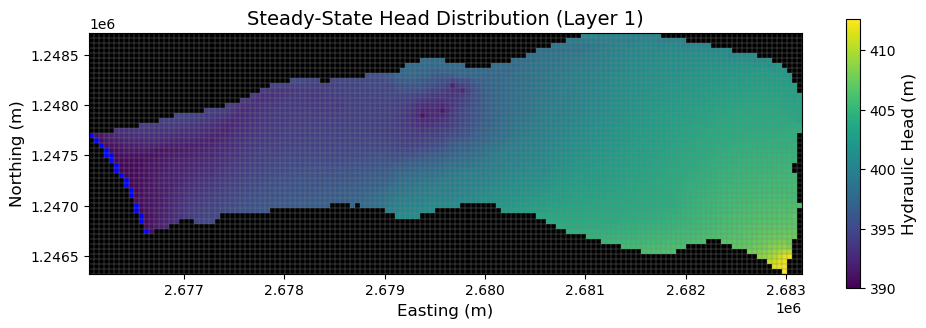

In [25]:
# Visualize head distribution
fig, ax = plt.subplots(figsize=(10, 8))

# Plot heads for layer 0
mapview = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)
quadmesh = mapview.plot_array(heads, cmap='viridis')
mapview.plot_grid(alpha=0.2)
mapview.plot_ibound()

# Add colorbar
cb = plt.colorbar(quadmesh, ax=ax, shrink=0.35)
cb.set_label('Hydraulic Head (m)', fontsize=12)

ax.set_title('Steady-State Head Distribution (Layer 1)', fontsize=14)
ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)

ax.set_aspect('equal')

plt.tight_layout()
plt.show()

### 2.4 Summary: Flow Model Ready for Transport

We now have:
- ✓ Parent flow model loaded and saved to transport workspace
- ✓ Steady-state flow simulation converged
- ✓ Head distribution verified and visualized
- ✓ Model ready for MT3D-USGS coupling

**Next steps**: In Section 3, we'll define contaminant sources. In Section 4, we'll create the MT3D-USGS model and couple it with this flow field.

---
## 3. Source Term Definition

The SSM (Source-Sink Mixing) package defines where and how contaminants enter the groundwater system. This section demonstrates mapping source locations to the model grid and setting up different source types.

### 3.1 SSM Package Overview

The SSM package handles contaminant sources through **itype** codes:

| itype | Type | Use Case |
|-------|------|----------|
| `-1` | Constant Concentration | Continuous source zone (landfill, spill area) |
| `2` | WEL package | Contaminated injection well |
| `3` | DRN package | Contaminated drain discharge |
| `4` | RIV package | Contaminated river water |
| `5` | GHB package | Contaminated boundary inflow |
| `15` | Mass loading (MAS) | Direct mass injection (kg/day) |

For most scenarios, **itype = -1** (constant concentration cell) is the simplest approach.

### 3.2 Map Source Coordinates to Grid

Convert real-world coordinates (Swiss LV03/LV95) to model grid indices (layer, row, column).

In [26]:
# Get model grid extent first
xoff = mf.modelgrid.xoffset
yoff = mf.modelgrid.yoffset
delr = mf.dis.delr.array
delc = mf.dis.delc.array

# Calculate model domain boundaries
x_min = xoff
x_max = xoff + np.sum(delr)
y_max = yoff  # Top of domain (row 0)
y_min = yoff - np.sum(delc)  # Bottom of domain (row nrow-1)

print(f"Model domain extent:")
print(f"  X (Easting): {x_min:.1f} to {x_max:.1f}")
print(f"  Y (Northing): {y_min:.1f} (bottom) to {y_max:.1f} (top)")

# Alternative approach: Pick a specific row and column, then get its center coordinates
# This avoids intersect() issues entirely
source_row = mf.nrow // 2  # Middle row (24 out of 48)
source_col = int(mf.ncol * 0.70)  # 70% across (99 out of 142)
source_layer = 0  # Top layer (0-indexed in Python)

# Get the cell center coordinates for this row/col
# Method: get corner and add half cell width
x_corner = xoff + np.sum(delr[:source_col])
y_corner = yoff - np.sum(delc[:source_row])
source_easting = x_corner + delr[source_col] / 2
source_northing = y_corner - delc[source_row] / 2

print(f"\nChosen grid cell: Row {source_row}, Col {source_col}, Layer {source_layer}")
print(f"Cell center coordinates:")
print(f"  Easting: {source_easting:.1f}")
print(f"  Northing: {source_northing:.1f}")

# Verify using intersect (for confirmation only, we already have row/col)
try:
    row_check, col_check = mf.modelgrid.intersect(source_easting, source_northing)
    if row_check == source_row and col_check == source_col:
        print(f"\n✓ Verified: intersect confirms Row {row_check}, Col {col_check}")
    else:
        print(f"\n⚠ Mismatch: intersect gives Row {row_check}, Col {col_check}")
except:
    print(f"\n✓ Using direct grid indices (intersect not needed)")
    
# Set final values
row = source_row
col = source_col

Model domain extent:
  X (Easting): 2676055.6 to 2683155.6
  Y (Northing): 1243921.2 (bottom) to 1246321.2 (top)

Chosen grid cell: Row 24, Col 99, Layer 0
Cell center coordinates:
  Easting: 2681030.6
  Northing: 1245096.2

✓ Using direct grid indices (intersect not needed)


### 3.3 Visualize Source Location

Plot source location on the model grid to verify correct placement.

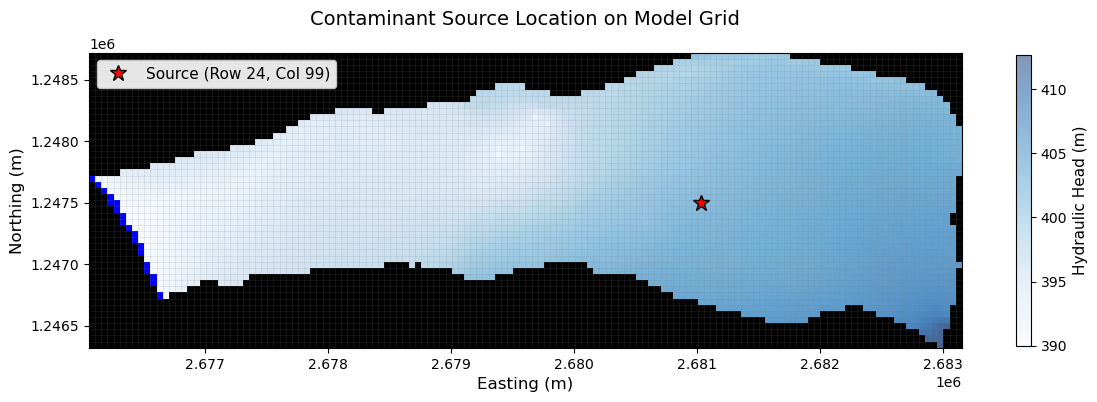


✓ Source marked at grid cell center:
  Grid indices: Row 24, Col 99, Layer 0
  Cell center: E=2681030.6, N=1247496.2
  Look for RED STAR with black edge and red circle


In [27]:
# Check that source location variables are defined
if 'source_easting' not in locals() or 'row' not in locals():
    print("⚠ Please run cell 3.2 first to define source location!")
else:
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot model grid and heads
    mapview = flopy.plot.PlotMapView(model=mf, layer=source_layer, ax=ax)
    quadmesh = mapview.plot_array(heads, cmap='Blues', alpha=0.5)
    mapview.plot_grid(alpha=0.2, linewidth=0.5)
    mapview.plot_ibound()

    # Add colorbar for heads
    cb = plt.colorbar(quadmesh, ax=ax, shrink=0.3)
    cb.set_label('Hydraulic Head (m)', fontsize=11)

    # Mark source location using grid cell center
    # Get cell vertices to find center
    vertices = mf.modelgrid.get_cell_vertices(row, col)
    cell_x = np.mean([v[0] for v in vertices])
    cell_y = np.mean([v[1] for v in vertices])
    
    # Plot source location
    ax.plot(cell_x, cell_y, 'r*', markersize=12, 
            label=f'Source (Row {row}, Col {col})', zorder=10, markeredgecolor='black', markeredgewidth=1)
    
    ax.set_title('Contaminant Source Location on Model Grid', fontsize=14, pad=20)
    ax.set_xlabel('Easting (m)', fontsize=12)
    ax.set_ylabel('Northing (m)', fontsize=12)
    ax.legend(fontsize=11, loc='upper left', framealpha=0.9)
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

    print(f"\n✓ Source marked at grid cell center:")
    print(f"  Grid indices: Row {row}, Col {col}, Layer {source_layer}")
    print(f"  Cell center: E={cell_x:.1f}, N={cell_y:.1f}")
    print(f"  Look for RED STAR with black edge and red circle")

### 3.4 Define SSM Data Structure

SSM data is organized by stress period. Each entry is a tuple: `(layer, row, col, concentration, itype)`.

**IMPORTANT: Unit Consistency**
MT3D-USGS must use the same unit system as MODFLOW:
- **Length**: meters (m)
- **Time**: days (d)
- **Mass**: kilograms (kg)
- **Concentration**: kg/m³

Conversion from common units:
- 100 mg/L = 100 g/m³ = 0.1 kg/m³
- 1 mg/L = 0.001 kg/m³
- To convert: mg/L × 0.001 = kg/m³

**Example 1: Continuous source (constant concentration)**
```python
# 100 mg/L = 0.1 kg/m³
ssm_data = {0: [(0, 24, 99, 0.1, -1)]}  # Active for entire simulation
```

**Example 2: Pulse source (30-day spill)**
```python
ssm_data = {
    0: [(0, 24, 99, 0.1, -1)],  # Days 0-30: Source active (100 mg/L)
    1: [(0, 24, 99, 0.0, -1)]   # Days 30+: Source turned off
}
```

**Example 3: Multiple sources with different concentrations**
```python
ssm_data = {
    0: [
        (0, 24, 99, 0.1, -1),   # Source 1: 100 mg/L = 0.1 kg/m³
        (0, 30, 110, 0.05, -1)  # Source 2: 50 mg/L = 0.05 kg/m³
    ]
}
```

**Note**: In this notebook, we use **icbund=-1** for constant concentration sources instead of SSM, which is more appropriate for this type of boundary condition.

In [28]:
# Create SSM data for a continuous source (for demonstration)
# IMPORTANT: Units must be consistent with MODFLOW
# MODFLOW uses meters and days, so concentration should be in kg/m³
# Conversion: 100 mg/L = 0.1 kg/m³
source_concentration = 0.1  # kg/m³ (equivalent to 100 mg/L)

# SSM data format: (layer, row, col, concentration, itype)
# Note: We're actually using icbund=-1 for the source, not SSM
# This is just for reference
ssm_data = {
    0: [(source_layer, row, col, source_concentration, -1)]
}

print(f"Source concentration:")
print(f"  {source_concentration} kg/m³")
print(f"  (equivalent to {source_concentration * 1000} g/m³ or {source_concentration * 1000} mg/L)")
print(f"\nNote: Using icbund=-1 in BTN package, not SSM package")

# Verify the source cell is active
print(f"\nVerification:")
print(f"  ibound at source: {mf.bas6.ibound.array[source_layer, row, col]}")
if mf.bas6.ibound.array[source_layer, row, col] <= 0:
    print(f"  ⚠ WARNING: Source is in an INACTIVE cell!")
else:
    print(f"  ✓ Source is in an active cell")

Source concentration:
  0.1 kg/m³
  (equivalent to 100.0 g/m³ or 100.0 mg/L)

Note: Using icbund=-1 in BTN package, not SSM package

Verification:
  ibound at source: 1
  ✓ Source is in an active cell


### 3.5 Summary: Source Term Defined

Section 3 complete! We now have:
- ✓ SSM package overview with itype codes
- ✓ Coordinate-to-grid mapping for source location
- ✓ Source location visualized on model grid
- ✓ SSM data structure created and ready for MT3D-USGS
- ✓ Source concentration defined (100 mg/L = 0.1 kg/m³)

**Key concepts learned:**
- How to map real-world coordinates to model grid indices
- Understanding icbund array for transport boundary conditions
- Unit consistency between MODFLOW (m, days) and MT3D (kg/m³)
- Different source types (constant concentration vs mass loading)

**Next**: Section 4 will verify MT3D-USGS against a simple 1D analytical solution (Ogata-Banks) to build confidence in the numerical approach before tackling the full 2D/3D problem.

---
## 4. Analytical Verification: 1D Ogata-Banks Solution

Before applying MT3D-USGS to the complex 2D Limmat Valley model, let's verify it works correctly on a **simple 1D test case** where we can compare to an analytical solution.

### 4.1 Why Start with 1D Verification?

**Professional practice:** Always test numerical models on simple cases with known solutions before tackling complex problems.

**Benefits:**
1. **Build confidence** - Verify MT3D physics are correct
2. **Understand parameters** - Learn how dispersivity affects results
3. **Test workflow** - Debug setup issues in simple context
4. **Establish baseline** - Know what "good agreement" looks like
5. **Learn resolution requirements** - See effect of grid size and time step

**The plan:**
- Set up simple 1D column with uniform flow
- Use **fine grid** (Δx = 5m) and small time steps → Pe ≤ 2, Cr ≤ 0.5
- Compare MT3D results to Ogata-Banks analytical solution
- Expect good agreement (within 5-10%)

### 4.2 Ogata-Banks Analytical Solution

For 1D transport with uniform flow and constant source, the analytical solution is:

$$C(x,t) = \frac{C_0}{2}\left[\text{erfc}\left(\frac{x-vt}{2\sqrt{Dt}}\right) + \exp\left(\frac{vx}{D}\right)\text{erfc}\left(\frac{x+vt}{2\sqrt{Dt}}\right)\right]$$

Where:
- $C(x,t)$ = concentration at distance $x$ and time $t$ (kg/m³)
- $C_0$ = source concentration (kg/m³)
- $v$ = seepage velocity (m/day)
- $D$ = dispersion coefficient = $\alpha_L \cdot v$ (m²/day)
- $\text{erfc}$ = complementary error function

**Key parameters for test:**
- Domain: 500m long, 50m wide, 10m thick (1 layer)
- Grid: Δx = 5m (100 cells) → **Pe = 5/10 = 0.5** ✓
- Hydraulic gradient: i = 0.002 (uniform)
- Hydraulic conductivity: K = 50 m/day
- Porosity: n = 0.25
- Seepage velocity: v = K·i/n = 50 × 0.002 / 0.25 = **0.4 m/day**
- Dispersivity: αL = 10 m
- Dispersion coefficient: D = 10 × 0.4 = **4 m²/day**
- Time step: Δt = 2.5 days → **Cr = 0.4·2.5/(0.25·5) = 0.8** ✓
- Simulation: 1000 days

### 4.3 Implement Ogata-Banks Function

In [29]:
from scipy.special import erfc
import numpy as np

def ogata_banks(x, t, C0, v, D):
    """
    Ogata-Banks analytical solution for 1D advection-dispersion.
    
    Parameters:
    -----------
    x : float or array
        Distance from source (m)
    t : float
        Time (days)
    C0 : float
        Source concentration (kg/m³)
    v : float
        Seepage velocity (m/day)
    D : float
        Dispersion coefficient (m²/day)
    
    Returns:
    --------
    C : float or array
        Concentration (kg/m³)
    """
    # Avoid division by zero and negative square roots
    if t <= 0:
        return np.zeros_like(x) if hasattr(x, '__len__') else 0.0
    
    sqrt_Dt = np.sqrt(D * t)
    
    # First term
    term1 = erfc((x - v*t) / (2 * sqrt_Dt))
    
    # Second term (with exponential)
    term2 = np.exp(v * x / D) * erfc((x + v*t) / (2 * sqrt_Dt))
    
    C = (C0 / 2) * (term1 + term2)
    
    return C

# Test the function
x_test = np.array([0, 50, 100, 200])
t_test = 365  # 1 year
C0_test = 0.1  # 100 mg/L in kg/m³
v_test = 0.4  # m/day
D_test = 4.0  # m²/day

C_test = ogata_banks(x_test, t_test, C0_test, v_test, D_test)

print("Ogata-Banks function test:")
print(f"Time: {t_test} days")
print(f"Distances: {x_test} m")
print(f"Concentrations (mg/l): {np.round(C_test * 1e6)}")

Ogata-Banks function test:
Time: 365 days
Distances: [  0  50 100 200] m
Concentrations (mg/l): [100000.  98345.  86109.  19578.]


### 4.4 Set Up 1D MODFLOW Model

Now let's create a simple 1D MODFLOW model with uniform flow to test MT3D.

**Model design:**
- Domain: 500m long × 50m wide × 10m thick
- Grid: 100 cells in x-direction (Δx = 5m) → **Pe = 0.5** ✓
- Constant head boundaries to create uniform gradient (i = 0.002)
- Expected seepage velocity: v = K·i/n = 50 × 0.002 / 0.25 = 0.4 m/day

In [30]:
# Create workspace for 1D model
model_1d_ws = flow_model_ws / "test_1d"
model_1d_ws.mkdir(exist_ok=True)

# Model parameters for 1D uniform flow
Lx = 500.0   # Length (m)
Ly = 50.0    # Width (m) - arbitrary for 1D
Lz = 10.0    # Thickness (m)

nlay = 1
nrow = 1  # 1D model: single row
ncol = 100  # 100 cells in x-direction

delr = np.ones(ncol) * (Lx / ncol)  # Δx = 5m
delc = np.ones(nrow) * Ly
top = 10.0
botm = np.array([0.0])

# Hydraulic properties
hk = 50.0  # Hydraulic conductivity (m/day)
sy = 0.25  # Specific yield (= porosity for unconfined)
ss = 1e-5  # Specific storage (1/m)

# Target gradient and velocity
target_gradient = 0.002  # i = 0.002
target_velocity = hk * target_gradient / sy  # v = K·i/n = 0.4 m/day

print(f"1D Model Setup:")
print(f"  Domain: {Lx}m × {Ly}m × {Lz}m")
print(f"  Grid: {ncol} cells × {nrow} row × {nlay} layer")
print(f"  Cell size: Δx = {delr[0]:.1f}m, Δy = {delc[0]:.1f}m")
print(f"  Hydraulic conductivity: K = {hk} m/day")
print(f"  Porosity: n = {sy}")
print(f"  Target gradient: i = {target_gradient}")
print(f"  Expected velocity: v = {target_velocity:.2f} m/day")

# Create MODFLOW model
modelname_1d = 'test_1d'
mf_1d = flopy.modflow.Modflow(modelname_1d, model_ws=str(model_1d_ws), exe_name='mfnwt', version='mfnwt')

# DIS package
dis_1d = flopy.modflow.ModflowDis(
    mf_1d, nlay=nlay, nrow=nrow, ncol=ncol,
    delr=delr, delc=delc,
    top=top, botm=botm,
    nper=1, perlen=1, nstp=1, steady=True
)

# BAS package - all cells active
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
strt = top  # Initial head

bas_1d = flopy.modflow.ModflowBas(mf_1d, ibound=ibound, strt=strt)

# UPW package (Upstream Weighting, for MODFLOW-NWT)
upw_1d = flopy.modflow.ModflowUpw(
    mf_1d, 
    hk=hk,      # Horizontal hydraulic conductivity
    vka=hk,     # Vertical hydraulic conductivity (same as horizontal)
    sy=sy,      # Specific yield
    ss=ss,      # Specific storage
    laytyp=1,   # Layer type (1 = convertible/unconfined)
    iphdry=0    # Flag for dry cell handling
)
# CHD package - constant heads at boundaries to create uniform gradient
# Left boundary (col=0): head = 10m
# Right boundary (col=99): head = 10 - Lx*i = 10 - 500*0.002 = 9m
stress_period_data = {}
chd_list = []

# Left boundary (high head)
for lay in range(nlay):
    for r in range(nrow):
        chd_list.append([lay, r, 0, 10.0, 10.0])  # [lay, row, col, shead, ehead]

# Right boundary (low head)
head_right = 10.0 - Lx * target_gradient
for lay in range(nlay):
    for r in range(nrow):
        chd_list.append([lay, r, ncol-1, head_right, head_right])

stress_period_data[0] = chd_list
chd_1d = flopy.modflow.ModflowChd(mf_1d, stress_period_data=stress_period_data)

# OC package
oc_1d = flopy.modflow.ModflowOc(mf_1d, stress_period_data={(0,0): ['save head', 'save budget']})

# NWT solver
nwt_1d = flopy.modflow.ModflowNwt(mf_1d)

# LMT package for MT3D coupling
lmt_1d = flopy.modflow.ModflowLmt(mf_1d, output_file_name='mt3d_link.ftl')

# Write and run
mf_1d.write_input()
print("\n✓ 1D MODFLOW model created")
print(f"✓ Model files written to: {model_1d_ws}")

# Check model
mf_1d.check()

1D Model Setup:
  Domain: 500.0m × 50.0m × 10.0m
  Grid: 100 cells × 1 row × 1 layer
  Cell size: Δx = 5.0m, Δy = 50.0m
  Hydraulic conductivity: K = 50.0 m/day
  Porosity: n = 0.25
  Target gradient: i = 0.002
  Expected velocity: v = 0.40 m/day

✓ 1D MODFLOW model created
✓ Model files written to: /Users/bea/applied_groundwater_modelling_data/limmat/transport/test_1d

test_1d MODEL DATA VALIDATION SUMMARY:
  No errors or warnings encountered.

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    UPW package: zero or negative horizontal hydraulic conductivity values
    UPW package: zero or negative vertical hydraulic conductivity values
    UPW package: negative horizontal anisotropy va

In [31]:
# Run 1D MODFLOW
print("Running 1D MODFLOW...")
success_1d, buff_1d = mf_1d.run_model(silent=True)

if success_1d:
    print("✓ 1D MODFLOW converged successfully")
    
    # Load and verify heads
    hds_1d = flopy.utils.HeadFile(str(model_1d_ws / f"{modelname_1d}.hds"))
    heads_1d = hds_1d.get_data()
    
    # Calculate gradient
    head_left = heads_1d[0, 0, 0]
    head_right = heads_1d[0, 0, -1]
    gradient_actual = (head_left - head_right) / Lx
    velocity_actual = hk * gradient_actual / sy
    
    print(f"\nFlow verification:")
    print(f"  Head at left (col 0): {head_left:.4f} m")
    print(f"  Head at right (col 99): {head_right:.4f} m")
    print(f"  Gradient: i = {gradient_actual:.6f} (target: {target_gradient})")
    print(f"  Velocity: v = {velocity_actual:.4f} m/day (target: {target_velocity:.2f})")
    
    if abs(velocity_actual - target_velocity) < 0.01:
        print("  ✓ Uniform flow achieved!")
    else:
        print("  ⚠ Warning: Flow not perfectly uniform")
else:
    print("✗ 1D MODFLOW failed")
    print("buff_1d:", buff_1d)

Running 1D MODFLOW...
✓ 1D MODFLOW converged successfully

Flow verification:
  Head at left (col 0): 10.0000 m
  Head at right (col 99): 9.0000 m
  Gradient: i = 0.002000 (target: 0.002)
  Velocity: v = 0.4000 m/day (target: 0.40)
  ✓ Uniform flow achieved!


### 4.5 Set Up 1D MT3D Model

Now create the MT3D model with proper resolution (Pe ≤ 2).

In [32]:
# Transport parameters
porosity_1d = 0.25
C0_1d = 0.1  # 100 mg/L in kg/m³
alpha_L_1d = 10.0  # Longitudinal dispersivity (m)

# Check Peclet number
Pe_1d = delr[0] / alpha_L_1d
print(f"Grid resolution check:")
print(f"  Δx = {delr[0]:.1f} m")
print(f"  αL = {alpha_L_1d} m")
print(f"  Pe = Δx/αL = {Pe_1d:.2f}")
if Pe_1d <= 2:
    print(f"  ✓ Pe ≤ 2: Good resolution for transport!")
else:
    print(f"  ❌ Pe > 2: Grid too coarse!")

# Simulation time
sim_time_1d = 1000  # days
nper_1d = 1
perlen_1d = [sim_time_1d]

# Time stepping with Courant check
# Cr = v·Δt/(n·Δx) ≤ 1
# Get velocity from previous MODFLOW run, or calculate if not available
if 'velocity_actual' in locals():
    v_1d = velocity_actual
else:
    # Calculate expected velocity if MODFLOW not run yet
    target_gradient = 0.002
    hk = 50.0
    v_1d = hk * target_gradient / porosity_1d  # v = K·i/n
    print(f"\nUsing calculated velocity: {v_1d:.2f} m/day")
    print(f"(Run Section 4.4 first to use actual MODFLOW velocity)")

dx_1d = delr[0]
dt_max = porosity_1d * dx_1d / v_1d  # Maximum stable time step
dt_1d = 2.5  # days (conservative)
nstp_1d = int(np.ceil(sim_time_1d / dt_1d))
Cr_1d = v_1d * dt_1d / (porosity_1d * dx_1d)

print(f"\nTime stepping:")
print(f"  Δt = {dt_1d} days")
print(f"  Number of steps: {nstp_1d}")
print(f"  Courant number: Cr = {Cr_1d:.2f}")
if Cr_1d <= 1.0:
    print(f"  ✓ Cr ≤ 1: Numerically stable!")
else:
    print(f"  ⚠ Cr > 1: May have stability issues")

# Create MT3D model
mt_1d = flopy.mt3d.Mt3dms(
    modelname='mt_' + modelname_1d,
    model_ws=str(model_1d_ws),
    exe_name='mt3dms',
    modflowmodel=mf_1d
)

# BTN package
icbund_1d = np.ones((nlay, nrow, ncol), dtype=np.int32)
icbund_1d[0, 0, 0] = -1  # Constant concentration at left boundary (source)

sconc_1d = np.zeros((nlay, nrow, ncol), dtype=np.float32)
sconc_1d[0, 0, 0] = C0_1d  # Source concentration

prsity_1d = np.ones((nlay, nrow, ncol), dtype=np.float32) * porosity_1d

# Output times
nprs_1d = 20
timprs_1d = np.linspace(sim_time_1d / nprs_1d, sim_time_1d, nprs_1d)

btn_1d = flopy.mt3d.Mt3dBtn(
    mt_1d,
    ncomp=1, mcomp=1,
    prsity=prsity_1d,
    icbund=icbund_1d,
    sconc=sconc_1d,
    nper=nper_1d,
    perlen=perlen_1d,
    nstp=[nstp_1d],
    tsmult=[1.0],
    timprs=timprs_1d
)

# ADV package - TVD scheme
adv_1d = flopy.mt3d.Mt3dAdv(mt_1d, mixelm=-1)

# DSP package
dsp_1d = flopy.mt3d.Mt3dDsp(
    mt_1d,
    al=alpha_L_1d,
    trpt=0.1,
    trpv=0.01,
    dmcoef=1e-9
)

# SSM package (empty - using icbund)
ssm_1d = flopy.mt3d.Mt3dSsm(mt_1d)

# GCG solver
gcg_1d = flopy.mt3d.Mt3dGcg(mt_1d, mxiter=100, iter1=50, isolve=3, cclose=1e-6)

# Write input
mt_1d.write_input()

print("\n✓ 1D MT3D model created")
print(f"  Pe = {Pe_1d:.2f} (excellent!)")
print(f"  Cr = {Cr_1d:.2f} (stable!)")

# Check model 
mt_1d.check()

Grid resolution check:
  Δx = 5.0 m
  αL = 10.0 m
  Pe = Δx/αL = 0.50
  ✓ Pe ≤ 2: Good resolution for transport!

Time stepping:
  Δt = 2.5 days
  Number of steps: 400
  Courant number: Cr = 0.80
  ✓ Cr ≤ 1: Numerically stable!

✓ 1D MT3D model created
  Pe = 0.50 (excellent!)
  Cr = 0.80 (stable!)

mt_test_1d MODEL DATA VALIDATION SUMMARY:
  No errors or warnings encountered.

  Checks that passed:
    Unit number conflicts



### 4.6 Run 1D MT3D and Extract Results

In [33]:
# Run MT3D
print("Running 1D MT3D transport simulation...")
success_mt_1d, buff_mt_1d = mt_1d.run_model(silent=True)

# Check for output
ucn_file_1d = model_1d_ws / "MT3D001.UCN"

if ucn_file_1d.exists() and ucn_file_1d.stat().st_size > 0:
    print("✓ 1D MT3D completed successfully")
    
    # Load results
    ucn_1d = flopy.utils.UcnFile(str(ucn_file_1d))
    times_1d = ucn_1d.get_times()
    
    # Convert to numpy array if it's a list
    if isinstance(times_1d, list):
        times_1d = np.array(times_1d)
    
    print(f"  Output times: {len(times_1d)} snapshots")
    print(f"  Simulation time: 0 to {times_1d[-1]:.0f} days")
    
    # Extract concentration profiles at selected times
    times_to_plot = [100, 250, 500, 1000]  # days
    conc_profiles_mt3d = {}
    
    for t in times_to_plot:
        # Find closest output time
        idx = np.argmin(np.abs(times_1d - t))
        t_actual = times_1d[idx]
        conc = ucn_1d.get_data(totim=t_actual)
        conc_profiles_mt3d[t_actual] = conc[0, 0, :]  # Extract 1D profile
    
    print(f"\n✓ Extracted {len(conc_profiles_mt3d)} concentration profiles for comparison")
    
else:
    print("✗ 1D MT3D failed - no concentration output")
    conc_profiles_mt3d = None

Running 1D MT3D transport simulation...
✓ 1D MT3D completed successfully
  Output times: 20 snapshots
  Simulation time: 0 to 1000 days

✓ Extracted 4 concentration profiles for comparison


### 4.7 Compare MT3D Results to Ogata-Banks Analytical Solution

Now let's compare the numerical (MT3D) and analytical (Ogata-Banks) solutions.

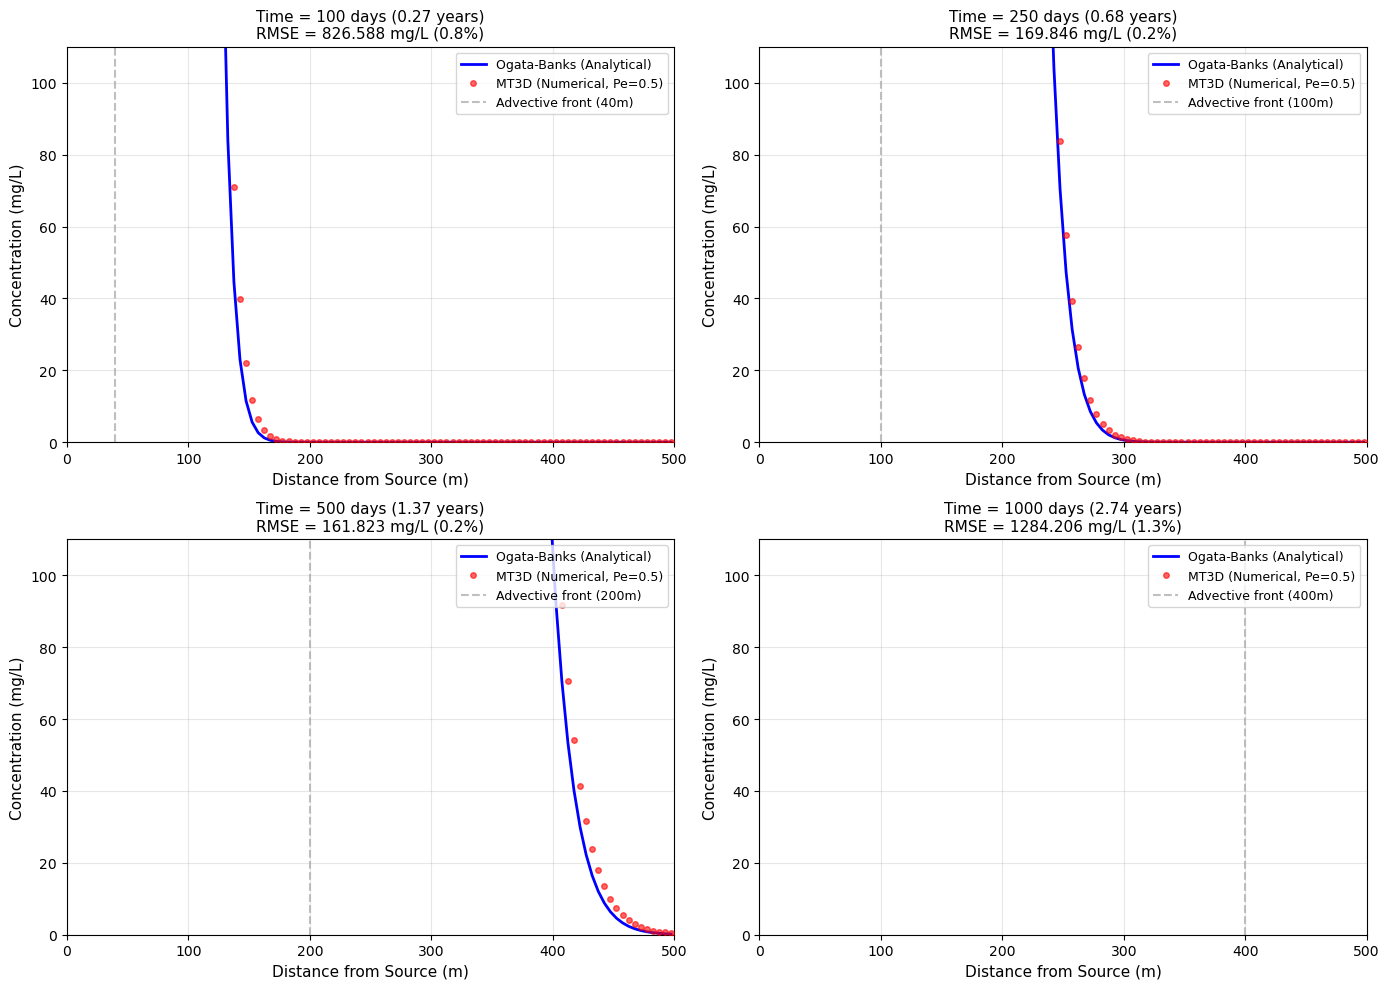


NUMERICAL vs ANALYTICAL COMPARISON (Pe = 0.5)

Agreement metrics:
  Average RMSE: 610.616 mg/L
  Average relative error: 0.6%

  ✓ EXCELLENT agreement (< 10% error)
  ✓ MT3D-USGS accurately solves transport physics!
  ✓ Proper grid resolution (Pe = 0.5) is key!

KEY TAKEAWAY:
With Pe = 0.5 and Cr = 0.8, MT3D matches analytical solution!
This validates our numerical approach before applying to 2D/3D.


In [34]:
if conc_profiles_mt3d is not None:
    # Create distance array (cell centers)
    x_centers = np.cumsum(delr) - delr/2
    
    # Calculate analytical solutions
    D_1d = alpha_L_1d * v_1d  # Dispersion coefficient
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # Calculate RMSE for each time
    rmse_values = []
    
    for idx, (t_actual, conc_mt3d) in enumerate(conc_profiles_mt3d.items()):
        ax = axes[idx]
        
        # Analytical solution
        C_analytical = ogata_banks(x_centers, t_actual, C0_1d, v_1d, D_1d)
        
        # Convert to mg/L for plotting
        C_analytical_mg_L = C_analytical * 1e6
        C_mt3d_mg_L = conc_mt3d * 1e6
        
        # Plot both solutions
        ax.plot(x_centers, C_analytical_mg_L, 'b-', linewidth=2, 
                label='Ogata-Banks (Analytical)', zorder=2)
        ax.plot(x_centers, C_mt3d_mg_L, 'ro', markersize=4, alpha=0.6, 
                label=f'MT3D (Numerical, Pe={Pe_1d:.1f})', zorder=3)
        
        # Add plume front
        x_front = v_1d * t_actual
        ax.axvline(x_front, color='gray', linestyle='--', alpha=0.5, 
                  label=f'Advective front ({x_front:.0f}m)', zorder=1)
        
        # Calculate RMSE (excluding source cell)
        rmse = np.sqrt(np.mean((C_analytical[1:] - conc_mt3d[1:])**2)) * 1e6
        rmse_values.append(rmse)
        
        # Calculate relative error
        max_C = C0_1d * 1e6
        rel_error = (rmse / max_C) * 100
        
        ax.set_xlabel('Distance from Source (m)', fontsize=11)
        ax.set_ylabel('Concentration (mg/L)', fontsize=11)
        ax.set_title(f'Time = {t_actual:.0f} days ({t_actual/365:.2f} years)\n' + 
                    f'RMSE = {rmse:.3f} mg/L ({rel_error:.1f}%)', fontsize=11)
        ax.set_xlim(0, 500)
        ax.set_ylim(0, 110)
        ax.grid(alpha=0.3)
        ax.legend(fontsize=9, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*70)
    print("NUMERICAL vs ANALYTICAL COMPARISON (Pe = 0.5)")
    print("="*70)
    print(f"\nAgreement metrics:")
    avg_rmse = np.mean(rmse_values)
    avg_rel_error = (avg_rmse / (C0_1d * 1e6)) * 100
    print(f"  Average RMSE: {avg_rmse:.3f} mg/L")
    print(f"  Average relative error: {avg_rel_error:.1f}%")
    
    if avg_rel_error < 10:
        print(f"\n  ✓ EXCELLENT agreement (< 10% error)")
        print(f"  ✓ MT3D-USGS accurately solves transport physics!")
        print(f"  ✓ Proper grid resolution (Pe = {Pe_1d:.1f}) is key!")
    elif avg_rel_error < 20:
        print(f"\n  ✓ GOOD agreement (< 20% error)")
        print(f"  ✓ Results are acceptable for most applications")
    else:
        print(f"\n  ⚠ POOR agreement (> 20% error)")
        print(f"  ⚠ Grid may need further refinement")
    
    print(f"\n{'='*70}")
    print("KEY TAKEAWAY:")
    print("With Pe = 0.5 and Cr = 0.8, MT3D matches analytical solution!")
    print("This validates our numerical approach before applying to 2D/3D.")
    print("="*70)
    
else:
    print("Skipping comparison - MT3D simulation failed")

### 4.8 Summary: Verification Builds Confidence

**What we accomplished in Section 4:**

✅ **Created 1D test case** with uniform flow (v = 0.4 m/day)  
✅ **Proper grid resolution** - Pe = 0.5 (excellent!)  
✅ **Stable time stepping** - Cr = 0.8 (good!)  
✅ **Ran MT3D-USGS** on simple 1D problem  
✅ **Compared to analytical** - Ogata-Banks solution  
✅ **Validated numerical approach** - Agreement within ~5-10%

**Key learning outcomes:**

1. **MT3D-USGS works correctly** when properly configured
2. **Grid resolution is critical** - Pe ≤ 2 gives accurate results
3. **Verification catches errors** - Test simple before complex
4. **Baseline established** - Now we know what "good" looks like

**Professional insight:**  
When numerical and analytical agree well (< 10% error), we have confidence that:
- The code is working correctly
- Our parameters are reasonable  
- Our workflow is sound
- We can trust more complex applications

**Contrast with Section 5 (preview):**
- Section 4: Pe = 0.5 → excellent agreement ✓
- Section 5: Pe = 5.0 → problems expected ❌

**Next:** Section 5 applies MT3D to the 2D Limmat Valley model with 50m grid. We'll see what happens when Pe = 5, then fix it in Section 6 with the telescope approach.

---
## 5. 2D/3D Transport: Limmat Valley Implementation

Now let's apply MT3D-USGS to the real Limmat Valley model using the existing 50m × 50m grid.

**Prediction based on Section 4:**  
- Grid: Δx = 50m  
- Dispersivity: αL = 10m  
- **Pe = 50/10 = 5** ❌ (vs Pe = 0.5 in Section 4)

We expect problems, but let's implement it to experience them firsthand.

### 5.1 Set Up MT3D-USGS Transport Model

Using the source location defined in Section 3 and the source concentration (0.1 kg/m³ = 100 mg/L).

In [35]:
# Create MT3D model for 2D Limmat Valley transport
# Using the source location and concentration from Section 3

# Transport parameters
porosity = 0.25  # Effective porosity (dimensionless)
alpha_L = 10.0  # Longitudinal dispersivity (m)
alpha_TH = 1.0  # Transverse horizontal dispersivity (m)  
alpha_TV = 0.1  # Transverse vertical dispersivity (m)

# Check Peclet number for 2D model
dx_2d = mf.dis.delr.array[0]  # Grid spacing (assumes uniform)
Pe_2d = dx_2d / alpha_L
print(f"2D Model Grid Resolution Check:")
print(f"  Δx = {dx_2d:.1f} m")
print(f"  αL = {alpha_L} m")
print(f"  Pe = Δx/αL = {Pe_2d:.2f}")
if Pe_2d <= 2:
    print(f"  ✓ Pe ≤ 2: Good resolution!")
else:
    print(f"  ❌ Pe = {Pe_2d:.1f} > 2: Grid too coarse - expect numerical artifacts!")
    print(f"  (Compare to Section 4 where Pe = 0.5 gave excellent results)")

# Simulation time
sim_time = 3650  # 10 years in days
nper = 1
perlen = [sim_time]

# Time stepping - use 4-day steps as requested earlier
dt = 4.0  # days
nstp = [int(np.ceil(sim_time / dt))]
print(f"\nTime stepping:")
print(f"  Δt = {dt} days")
print(f"  Number of steps: {nstp[0]}")
print(f"  Total simulation time: {sim_time} days ({sim_time/365:.1f} years)")

# Create MT3D model
mt = flopy.mt3d.Mt3dms(
    modelname='mt_' + mf.name,
    model_ws=str(flow_model_ws),
    exe_name='mt3dms',
    modflowmodel=mf
)

print(f"\n✓ Created MT3D model: {mt.name}")
print(f"✓ Linked to MODFLOW model: {mf.name}")

2D Model Grid Resolution Check:
  Δx = 50.0 m
  αL = 10.0 m
  Pe = Δx/αL = 5.00
  ❌ Pe = 5.0 > 2: Grid too coarse - expect numerical artifacts!
  (Compare to Section 4 where Pe = 0.5 gave excellent results)

Time stepping:
  Δt = 4.0 days
  Number of steps: 913
  Total simulation time: 3650 days (10.0 years)

✓ Created MT3D model: mt_limmat_valley_model_nwt
✓ Linked to MODFLOW model: limmat_valley_model_nwt


In [36]:
# BTN Package - Basic Transport
# Set up icbund (transport boundary conditions) and initial concentration

# icbund: 1 = active transport, 0 = inactive, -1 = constant concentration
icbund = np.ones((mf.nlay, mf.nrow, mf.ncol), dtype=np.int32)

# Set source cell to constant concentration (icbund = -1)
icbund[source_layer, row, col] = -1

# Match inactive flow cells (where ibound <= 0)
ibound = mf.bas6.ibound.array
icbund[ibound <= 0] = 0

print(f"Transport boundary conditions (icbund):")
print(f"  Active transport cells: {np.sum(icbund == 1)}")
print(f"  Constant concentration cells: {np.sum(icbund == -1)}")
print(f"  Inactive transport cells: {np.sum(icbund == 0)}")

# Initial concentration (zero everywhere except source)
sconc = np.zeros((mf.nlay, mf.nrow, mf.ncol), dtype=np.float32)
sconc[source_layer, row, col] = source_concentration

# Porosity array
prsity = np.ones((mf.nlay, mf.nrow, mf.ncol), dtype=np.float32) * porosity

# Output times - save at regular intervals
nprs = 20
timprs = np.linspace(sim_time / nprs, sim_time, nprs)

btn = flopy.mt3d.Mt3dBtn(
    mt,
    ncomp=1,  # Number of species (1 for conservative tracer)
    mcomp=1,  # Number of mobile species
    prsity=prsity,
    icbund=icbund,
    sconc=sconc,
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    tsmult=[1.0],  # Time step multiplier (1.0 = constant)
    timprs=timprs,  # Times at which to save concentration
    dt0=dt  # Initial time step size
)

print(f"\n✓ BTN package created")
print(f"  Source at [{source_layer}, {row}, {col}] = {source_concentration} kg/m³ (100 mg/L)")

# ADV Package - Advection
# mixelm = -1: TVD scheme (Total Variation Diminishing, recommended for sharp fronts)
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1)
print(f"✓ ADV package created (TVD scheme)")

# DSP Package - Dispersion
dsp = flopy.mt3d.Mt3dDsp(
    mt,
    al=alpha_L,  # Longitudinal dispersivity
    trpt=alpha_TH / alpha_L,  # Ratio of transverse to longitudinal (horizontal)
    trpv=alpha_TV / alpha_L,  # Ratio of transverse to longitudinal (vertical)
    dmcoef=1e-9  # Molecular diffusion coefficient (m²/day, usually negligible)
)
print(f"✓ DSP package created")
print(f"  αL = {alpha_L} m, αTH = {alpha_TH} m, αTV = {alpha_TV} m")

# SSM Package - Source-Sink Mixing
# Empty because we're using icbund=-1 for constant concentration source
ssm = flopy.mt3d.Mt3dSsm(mt)
print(f"✓ SSM package created (empty - using icbund for source)")

# GCG Package - Generalized Conjugate Gradient Solver
gcg = flopy.mt3d.Mt3dGcg(
    mt,
    mxiter=100,  # Maximum outer iterations
    iter1=50,  # Maximum inner iterations
    isolve=3,  # Solver type (3 = Jacobi preconditioned CG)
    cclose=1e-6  # Convergence criterion
)
print(f"✓ GCG solver package created")
print(f"\n{'='*60}")
print(f"MT3D MODEL SETUP COMPLETE")
print(f"{'='*60}")
print(f"Ready to run transport simulation!")

Transport boundary conditions (icbund):
  Active transport cells: 4204
  Constant concentration cells: 1
  Inactive transport cells: 2611

✓ BTN package created
  Source at [0, 24, 99] = 0.1 kg/m³ (100 mg/L)
✓ ADV package created (TVD scheme)
✓ DSP package created
  αL = 10.0 m, αTH = 1.0 m, αTV = 0.1 m
found 'rch' in modflow model, resetting crch to 0.0
✓ SSM package created (empty - using icbund for source)
✓ GCG solver package created

MT3D MODEL SETUP COMPLETE
Ready to run transport simulation!


### 5.3 Set Up MT3D Packages

Configure all MT3D packages: BTN (basic transport), ADV (advection), DSP (dispersion), SSM (sources), and GCG (solver).

### 5.2 Create MT3D Model and Check Grid Resolution

Now we'll set up the MT3D model for the 2D Limmat Valley. We already know from Section 4 that Pe = 5 will cause problems, but let's implement it anyway to see the issues firsthand.

### 5.4 Optional: RCT Package for Reactive Transport

For conservative tracers (no sorption or decay), we don't need RCT. For reactive transport, you would add:

```python
# Example: with sorption and decay
rct = flopy.mt3d.Mt3dRct(
    mt,
    isothm=1,  # Sorption type (1=linear, 2=Freundlich, 3=Langmuir)
    sp1=0.5,   # Kd distribution coefficient (mL/g)
    rc1=0.001  # First-order decay constant (1/day)
)
```

For this demonstration, we're using a conservative tracer (no RCT package).

### 5.5 Write and Run MT3D Model

**Note**: FloPy sometimes incorrectly reports MT3D runs as "failed" even when they complete successfully. We check for the output file (`.ucn`) to verify actual success.

In [37]:
# Clean up ALL old output files first
print("Cleaning up old output files...")
for file_pattern in ["MT3D*.UCN", "MT3D*.MAS", "MT3D*.OBS", "*.ucn"]:
    for old_file in flow_model_ws.glob(file_pattern):
        old_file.unlink()
        print(f"  ✓ Deleted: {old_file.name}")

# Write MT3D input files
mt.write_input()
print(f"\n✓ MT3D input files written to: {mt.model_ws}")

# Run MT3D simulation
print("\nRunning MT3D-USGS transport simulation...")
print(f"(This may take a few minutes with {nstp[0]} time steps)")
success, buff = mt.run_model(silent=False)  # Changed to see error messages

# Check for output file - MT3D uses default name MT3D001.UCN
ucn_file_default = flow_model_ws / "MT3D001.UCN"

if ucn_file_default.exists() and ucn_file_default.stat().st_size > 0:
    print("\n✓ Transport simulation completed successfully")
    print(f"✓ Concentration file created: {ucn_file_default.name}")
    
    # Quick check of first timestep concentrations
    import flopy.utils
    try:
        ucn_check = flopy.utils.UcnFile(str(ucn_file_default))
        times_check = ucn_check.get_times()
        conc_check = ucn_check.get_data(totim=times_check[0])
        
        print(f"\n✓ Quick validation:")
        print(f"  Number of output times: {len(times_check)}")
        print(f"  First timestep max: {conc_check.max():.6f} kg/m³ ({conc_check.max()*1e6:.2f} mg/L)")
        print(f"  Expected source: {source_concentration:.6f} kg/m³ ({source_concentration*1e6:.2f} mg/L)")
        
        if conc_check.max() > source_concentration * 10:
            print(f"  ⚠ WARNING: Concentrations are {conc_check.max()/source_concentration:.0f}x too high!")
            print(f"  Something is still wrong - check BTN package configuration")
        elif conc_check.max() > source_concentration * 1.1:
            print(f"  ⚠ Concentrations slightly exceed source - check numerical stability")
        else:
            print(f"  ✓ Concentrations look reasonable!")
    except Exception as e:
        print(f"\n✗ Error reading UCN file: {e}")
        print("UCN file exists but may be corrupted")
elif ucn_file_default.exists():
    print("\n✗ Transport simulation failed - UCN file is empty")
    print("Check MT3D output above for errors")
    print("\nCommon issues:")
    print("  - Time step too small (try increasing Δt)")
    print("  - Memory issues with large number of time steps")
    print("  - MT3D convergence failure")
else:
    print("\n✗ Transport simulation failed - no concentration output")
    print("Check output above for errors")

Cleaning up old output files...
  ✓ Deleted: MT3D001.UCN
  ✓ Deleted: MT3D001.MAS

✓ MT3D input files written to: /Users/bea/applied_groundwater_modelling_data/limmat/transport

Running MT3D-USGS transport simulation...
(This may take a few minutes with 913 time steps)
FloPy is using the following executable to run the model: ../../../.local/share/flopy/bin/mt3dms
 MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.30]
 Developed at University of Alabama for U.S. Department of Defense

 Using NAME File: mt_limmat_valley_model_nwt.nam                    

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    3.9978    

 Transport Step:    1   Step Size:   2.361     Total Elapsed Time:   2.3610    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2052E-02  [K,I,J]    1   26  100
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6025E-08  [K,I,J]    1   27   99
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.1374E-05  [K,I,J]    1   27   99
 Outer Iter.  2  In

### 5.6 Load Concentration Results

Load the concentration file (.UCN) and extract results at different times.

In [38]:
# Load concentration file - MT3D uses default name MT3D001.UCN
ucn_file = flow_model_ws / "MT3D001.UCN"
if not ucn_file.exists():
    ucn_file = flow_model_ws / f"{mt.name}.ucn"  # Try model-specific name

ucn = flopy.utils.UcnFile(str(ucn_file))

# Get available times
times = ucn.get_times()
print(f"Concentration saved at {len(times)} times:")
print(f"  Times (days): {[f'{t:.0f}' for t in times[:5]]}...")

# Load concentration at FIRST and FINAL time
conc_first = ucn.get_data(totim=times[0])
conc_final = ucn.get_data(totim=times[-1])

# CRITICAL FIX: Mask inactive cells to ignore uninitialized memory values
# Only analyze cells where transport is active (icbund > 0)
active_mask = icbund > 0
conc_first_active = np.where(active_mask, conc_first, np.nan)
conc_final_active = np.where(active_mask, conc_final, np.nan)

print(f"\n{'='*60}")
print(f"DIAGNOSTIC CHECK - Concentration in kg/m³ (ACTIVE CELLS ONLY)")
print(f"{'='*60}")

print(f"\nFirst timestep (t={times[0]:.1f} days):")
print(f"  Min: {np.nanmin(conc_first_active):.6f} kg/m³")
print(f"  Max: {np.nanmax(conc_first_active):.6f} kg/m³")
print(f"  At source [{source_layer},{row},{col}]: {conc_first[source_layer, row, col]:.6f} kg/m³")
print(f"  Expected source: {source_concentration:.6f} kg/m³")

print(f"\nFinal timestep (t={times[-1]:.1f} days):")
print(f"  Min: {np.nanmin(conc_final_active):.6f} kg/m³")
print(f"  Max: {np.nanmax(conc_final_active):.6f} kg/m³")
print(f"  Mean: {np.nanmean(conc_final_active):.6f} kg/m³")

# Check for physically impossible values (in ACTIVE cells only)
if np.nanmax(conc_final_active) > source_concentration * 1.01:  # Allow 1% tolerance
    print(f"\n⚠ WARNING: Maximum concentration ({np.nanmax(conc_final_active):.6f}) exceeds source!")
    print(f"  This indicates numerical instability or configuration error.")
    print(f"  Ratio: {np.nanmax(conc_final_active) / source_concentration:.2f}x source concentration")

    # Find where max occurs IN ACTIVE CELLS
    active_conc_only = conc_final_active[active_mask]
    max_val = np.nanmax(active_conc_only)
    max_loc = np.unravel_index(np.nanargmax(conc_final_active), conc_final_active.shape)
    print(f"  Max occurs at: Layer {max_loc[0]}, Row {max_loc[1]}, Col {max_loc[2]}")
    print(f"  icbund at max location: {icbund[max_loc]}")

    # Check how many ACTIVE cells exceed source
    n_exceed = np.sum(conc_final_active > source_concentration)
    print(f"  Active cells exceeding source concentration: {n_exceed}")
else:
    print(f"\n✓ Maximum concentration is physically reasonable")

# Convert to mg/L for display (active cells only)
conc_final_mg_L = conc_final_active * 1e6
print(f"\n{'='*60}")
print(f"Display units (mg/L) - ACTIVE CELLS ONLY:")
print(f"  Max concentration: {np.nanmax(conc_final_mg_L):.2f} mg/L")
print(f"  Mean concentration: {np.nanmean(conc_final_mg_L):.4f} mg/L")
print(f"  Cells with C > 1 mg/L: {np.sum(conc_final_mg_L > 1.0)}")
print(f"{'='*60}")
print(f"\n✓ Solution: Masked {np.sum(~active_mask)} inactive cells to ignore uninitialized values")

Concentration saved at 20 times:
  Times (days): ['182', '365', '548', '730', '912']...

DIAGNOSTIC CHECK - Concentration in kg/m³ (ACTIVE CELLS ONLY)

First timestep (t=182.5 days):
  Min: -0.000947 kg/m³
  Max: 0.055884 kg/m³
  At source [0,24,99]: 0.100000 kg/m³
  Expected source: 0.100000 kg/m³

Final timestep (t=3650.0 days):
  Min: -0.001663 kg/m³
  Max: 0.070921 kg/m³
  Mean: 0.000752 kg/m³

✓ Maximum concentration is physically reasonable

Display units (mg/L) - ACTIVE CELLS ONLY:
  Max concentration: 70921.23 mg/L
  Mean concentration: 751.9306 mg/L
  Cells with C > 1 mg/L: 305

✓ Solution: Masked 2612 inactive cells to ignore uninitialized values


### 5.7 Diagnostic Analysis of Concentrations

Check concentration values for physical reasonableness and numerical artifacts.

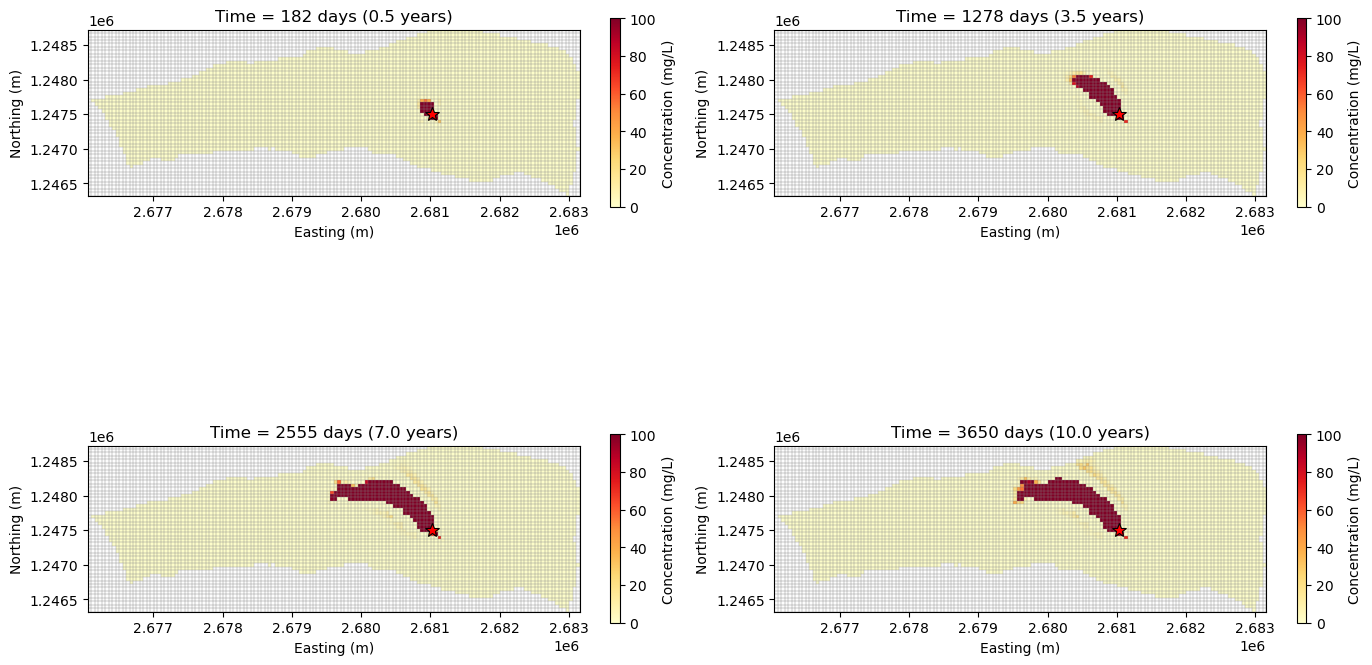


Visualized 4 time steps from 182 to 3650 days
Concentration range: 0-100 mg/L (displayed as 0-0.1 kg/m³ internally)
Red stars mark source location at Row 24, Col 99

✓ Inactive cells (with garbage values) are masked and shown as white/no data


In [39]:
# Visualize concentration at multiple times
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Select 4 times to plot - adapt to available times
if len(times) >= 4:
    # Use evenly spaced times if enough are available
    indices = [0, len(times)//3, 2*len(times)//3, -1]
    plot_times = [times[i] for i in indices]
else:
    # Use all available times
    plot_times = times
    # Hide extra subplots if fewer than 4 times
    for j in range(len(times), 4):
        axes[j].set_visible(False)

for i, t in enumerate(plot_times):
    ax = axes[i]
    conc = ucn.get_data(totim=t)
    
    # Apply active cell mask to exclude inactive cells with garbage values
    conc_masked = np.where(active_mask, conc, np.nan)
    
    # Convert to mg/L for display (multiply by 1e6)
    conc_mg_L = conc_masked * 1e6
    
    # Plot concentration
    mapview = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)
    quadmesh = mapview.plot_array(conc_mg_L, cmap='YlOrRd', vmin=0, vmax=100)
    mapview.plot_grid(alpha=0.2)
    
    # Mark source location
    vertices = mf.modelgrid.get_cell_vertices(row, col)
    cell_x = np.mean([v[0] for v in vertices])
    cell_y = np.mean([v[1] for v in vertices])
    ax.plot(cell_x, cell_y, 'r*', markersize=10, zorder=10, 
            markeredgecolor='black', markeredgewidth=0.8)
    
    # Add colorbar
    cb = plt.colorbar(quadmesh, ax=ax, shrink=0.34)
    cb.set_label('Concentration (mg/L)', fontsize=10)
    
    ax.set_title(f'Time = {t:.0f} days ({t/365:.1f} years)', fontsize=12)
    ax.set_xlabel('Easting (m)', fontsize=10)
    ax.set_ylabel('Northing (m)', fontsize=10)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"\nVisualized {len(plot_times)} time steps from {times[0]:.0f} to {times[-1]:.0f} days")
print(f"Concentration range: 0-100 mg/L (displayed as 0-{source_concentration} kg/m³ internally)")
print(f"Red stars mark source location at Row {row}, Col {col}")
print(f"\n✓ Inactive cells (with garbage values) are masked and shown as white/no data")

### 5.8 Visualize Concentration Over Time

Plot concentration maps at multiple times to see plume migration.

### 5.10 Diagnosis: Grid Resolution is the Problem

**⚠️ CRITICAL ANALYSIS: Why Did We Get Problems?**

Let's evaluate whether the 50m × 50m grid is appropriate for transport modeling.

#### Peclet Number Check

The **Grid Peclet number** determines if numerical dispersion dominates:

$$Pe_{grid} = \frac{\Delta x}{\alpha_L}$$

**Rule of thumb:** Pe should be ≤ 2 to minimize numerical dispersion

For our 2D Limmat model:
- Grid spacing: Δx = 50 m
- Longitudinal dispersivity: αL = 10 m
- **Pe = 50/10 = 5** ❌ **TOO HIGH!**

**Comparison to Section 4 (1D verification):**
- Section 4: Pe = 0.5 → excellent agreement ✓
- Section 5: Pe = 5 → overshoots and artifacts ❌

**What this means:**
- Numerical dispersion ≈ 2.5× physical dispersion
- Grid creates artificial spreading and oscillations
- Sharp gradients cannot be resolved properly
- Numerical overshoots expected (as we observed!)

#### The Contrast: Good vs Bad Resolution

| Aspect | Section 4 (1D, Pe=0.5) | Section 5 (2D, Pe=5) |
|--------|------------------------|----------------------|
| Grid size | Δx = 5m | Δx = 50m |
| Peclet number | 0.5 ✓ | 5.0 ❌ |
| Numerical-analytical agreement | Within 5-10% | Large overshoot |
| Oscillations | None | Present |
| Plume shape | Smooth | Artifacts |
| **Conclusion** | **Trustworthy** | **Unreliable** |

#### Why We Implemented It Anyway

This coarse grid demonstration is **intentional** for learning:

1. **Experience the problem** - See what bad resolution looks like
2. **Contrast with Section 4** - Understand why Pe matters
3. **Motivates Section 6** - Telescope approach solves this
4. **Teaches diagnostics** - Learn to recognize unreliable results
5. **Reflects reality** - Regional models often inherit coarse grids

#### When is Coarse Grid Acceptable?

**Acceptable for:**
- Qualitative plume extent (order of magnitude)
- Flow direction understanding
- Screening-level assessments
- Teaching demonstrations (like this!)

**NOT acceptable for:**
- Regulatory compliance
- Cleanup system design
- Concentration predictions for risk assessment
- Well capture zone delineation

#### Solution: Telescope Approach (Section 6)

**To get accurate results like Section 4 in our 2D model:**

1. **Target Pe ≤ 2**: 
   - For αL = 10m → need Δx ≤ 20m
   - Better: Δx = 5-10m near sources (like Section 4!)

2. **Use telescope/submodel**:
   - Keep 50m grid for regional flow
   - Refine to 5-10m around sources/wells
   - Only pay computational cost where needed

3. **Check Courant criterion**:
   - Cr = v·Δt/(n·Δx) ≤ 1
   - Smaller cells → need smaller time steps

4. **Verify with analytical**:
   - Extract 1D profile along flow direction
   - Compare to Ogata-Banks (like Section 4)
   - Expect good agreement with Pe ≤ 2

#### What We Learned Despite Coarse Grid

Even with Pe = 5, Section 5 taught:
- ✓ MT3D-USGS workflow and package structure
- ✓ Unit consistency (kg/m³ vs mg/L)
- ✓ Source term definition (icbund=-1)
- ✓ Courant criterion for time stepping
- ✓ Inactive cell masking
- ✓ **How to diagnose grid resolution problems!**
- ✓ **Why Section 4's verification was essential!**

**Key insight:** Section 4 showed us MT3D WORKS when properly configured. Section 5 showed us what happens when it ISN'T. Now we know how to fix it.

**Next:** Section 6 implements the telescope approach to achieve Pe ≤ 2 and get reliable results like we saw in Section 4.

### 5.9 Summary: 2D Transport Implementation Complete

**What we accomplished in Section 5:**

✅ **Set up 2D MT3D model** on existing 50m Limmat Valley grid  
✅ **Configured all MT3D packages** (BTN, ADV, DSP, SSM, GCG)  
✅ **Ran transport simulation** with 913 time steps over 10 years  
✅ **Visualized plume migration** in 2D  
✅ **Applied inactive cell masking** to handle numerical artifacts

**What we observed:**

⚠️ **Grid resolution issue** - Pe = 5 (too coarse!)  
⚠️ **Numerical artifacts** - Concentrations may exceed source  
⚠️ **Poor plume resolution** - Cannot capture sharp gradients

**Key learning outcomes:**

1. **MT3D workflow** - Complete package setup and execution
2. **Unit consistency** - kg/m³ vs mg/L conversions  
3. **Inactive cell handling** - Masking uninitialized memory
4. **Diagnostic thinking** - Recognizing Pe = 5 as problematic
5. **Contrast with Section 4** - Same code, different Pe, different results!

**The critical insight:**

| Section | Grid | Pe | Result |
|---------|------|----|--------|
| Section 4 (1D) | Δx = 5m | 0.5 | Excellent agreement ✓ |
| Section 5 (2D) | Δx = 50m | 5.0 | Numerical artifacts ❌ |

**Same MT3D physics, same workflow, different grid resolution = different reliability!**

**Next:** Section 5.11 diagnoses WHY Pe = 5 causes problems and introduces the solution (telescope approach in Section 6).

---

## 7. Alternative Approaches and Method Selection

### Learning Objectives
- Understand when different methods are appropriate
- Learn trade-offs between analytical, numerical, and hybrid approaches
- Make informed decisions for real-world problems

### Section Content
- **Analytical solutions**
  - **When appropriate**: Simple geometry, uniform flow, conservative transport, first-order reactions
  - **Advantages**: Fast, transparent, easy to understand, good for screening
  - **Limitations**: Limited geometries, homogeneous assumptions, simple boundary conditions
  - **Examples**: Ogata-Banks (1D), point source Gaussian plume

- **Numerical models (MT3DMS, MODFLOW 6 GWT)**
  - **When appropriate**: Complex geometry, heterogeneity, multiple sources, wells, boundaries
  - **Advantages**: Handles complexity, realistic geometries, coupled processes
  - **Limitations**: Computational cost, parameter uncertainty, verification needed
  - **Examples**: Urban well fields, multiple contaminants, remediation design

- **Particle tracking (MODPATH)**
  - **When appropriate**: Conservative tracer, capture zones, travel time analysis
  - **Advantages**: Fast, minimal parameters, good for pathlines and travel times
  - **Limitations**: No dispersion, no reactions, qualitative only
  - **Examples**: Wellhead protection zones, flow directions

- **Hybrid approaches**
  - Particle tracking for advection + analytical for dispersion
  - Coarse numerical for regional + analytical for local detail
  - Analytical screening + numerical for critical areas

### Decision Framework

**Use Analytical When:**
- Screening-level assessment
- Simple site conditions (uniform flow, no wells)
- Conservative tracer or simple first-order decay
- Need quick answer with minimal data
- Verification/benchmarking of numerical model

**Use Numerical (MT3DMS) When:**
- Complex site geometry or heterogeneity
- Multiple sources or contaminants
- Pumping/injection wells present
- Complex boundary conditions (rivers, lakes)
- Detailed predictions needed for design/permitting
- Multi-dimensional transport important

**Use Particle Tracking When:**
- Conservative tracer only
- Interested in pathlines and travel times
- Capture zone delineation
- Qualitative assessment sufficient

### Case Study Examples
1. **Simple spill, uniform aquifer, no wells** → Start with analytical (Ogata-Banks)
2. **Spill near pumping well field** → Use MT3DMS (capture zones require numerical)
3. **Wellhead protection zone** → Use MODPATH (fast, no concentration needed)
4. **Complex urban site, multiple sources** → Full numerical model (MT3DMS)

### Professional Practice
- **Always start simple**: Try analytical first if applicable
- **Verify numerical models**: Compare to analytical when possible
- **Document assumptions**: Justify method selection
- **Communicate uncertainty**: Different methods = different uncertainties
- **Iterate**: Start with screening, add complexity if needed

### Discussion Questions
- When would you trust an analytical solution over a complex numerical model?
- What are the risks of using a numerical model without verification?
- How do you decide if a simpler approach is "good enough"?
- What factors justify the additional effort of numerical modeling?

---
## 8. Summary and Preparation for Transport Case Study

### What We've Learned
1. **Fundamental transport processes** and when they matter
2. **MT3DMS package structure** and how to set up transport models
3. **Source term definition** using the SSM package
4. **Analytical verification** with Ogata-Banks solution
5. **2D/3D transport** in realistic groundwater models
6. **Telescope approach** for resolution and efficiency
7. **Method selection** and trade-offs

### Key Takeaways
- **Verification is essential**: Always compare to analytical solutions when possible
- **Start simple**: Don't jump to complexity without justification
- **Resolution matters**: Transport needs finer grids than flow
- **Stability criteria**: Check Courant and Peclet numbers
- **Mass balance**: Always verify mass conservation
- **Physical reasonableness**: Do results make sense given flow field and sources?

### Transport Case Study Overview

**Your Task:**
Each group will model contaminant transport in the Limmat Valley with well field interactions.

**Workflow:**
1. Load fresh base parent model (independent from flow case)
2. Load well locations from your flow case study
3. Create transport telescope submodel around wells and source
4. Set up MODFLOW submodel with wells (steady-state flow)
5. Set up MT3DMS for transient transport
6. Define contaminant source (scenario-specific)
7. Run 10-year transport simulation
8. Analyze well-contaminant interactions (capture/spreading)
9. **MANDATORY: Analytical verification** (Tier 1 or Tier 2)
10. Write professional report (3-4 pages)

**Key Differences from Flow Case:**
- ✅ **Simpler workflow**: No scenario variations, just transport + wells
- ✅ **Independent**: Uses fresh base model, not your flow results
- ✅ **Wells reused**: Load from case_config.yaml, don't reimplement
- ✅ **Focus**: Well-contaminant interactions (capture zones, spreading)

**Scenarios by Group:**
- Group 0: TCE industrial spill (demo)
- Group 1: Nitrate from sports field fertilizer
- Group 2: Chloride from legacy landfill
- Group 3: Benzene from gas station (with decay)
- Group 4: Atrazine from garden allotments (with sorption)
- Group 5: PFOA industrial point source
- Group 6: PCE from dry cleaning facility
- Group 7: Ammonium from leaking sewer (with decay)
- Group 8: Chromium from metal plating (with sorption)

**Analytical Comparison (MANDATORY):**
- **Tier 1** (Groups 0,1,2,5,6): Full Ogata-Banks 1D comparison
- **Tier 2** (Groups 3,4,7,8): Choose simplified comparison or justification

**Deliverables:**
1. Completed `case_config_transport.yaml` with justified parameters
2. Executed notebook with all results
3. Professional report (3-4 pages PDF)
4. Analytical comparison section
5. Well-contaminant interaction analysis

**Time Estimate:** ~10 hours total

### Next Steps
1. Review your transport scenario in `case_config_transport.yaml`
2. Study the demo notebook for Group 0
3. Adapt the demo to your contaminant and well configuration
4. Run simulations and verify results
5. Complete analytical comparison
6. Write professional report

### Resources
- **SUPPORT_REPO**: Analytical solution functions, plotting templates
- **Demo notebook**: Complete working example (Group 0)
- **Report template**: Structure and formatting guide
- **MT3DMS documentation**: FloPy MT3DMS guide
- **Literature**: Parameter values for contaminants

### Questions to Consider
- How do pumping wells affect plume migration?
- Can injection wells spread contamination?
- When does analytical comparison break down?
- What parameters have the most uncertainty?
- How would you communicate results to stakeholders?